# Create the Bayesian Network

In [25]:
import pandas as pd
import pickle
from pgmpy.models import BayesianNetwork
import networkx as nx
from utils import hierarchical_layout,draw_graph

# Import the pre-processed dataset and its values mapping
data = pd.read_csv("./dataset_final.csv")
with open('label_mappings.pkl', 'rb') as f: label_mappings = pickle.load(f)

## Different models

1. [Model-1: Baseline network](#model-1-baseline-network)
2. [Model-2: Network with a latent variable ](#model-2-network-with-a-latent-variable)
3. [Model-3: Network with unified variables](#model-3-network-with-unified-variables)

### Model-1: Baseline network

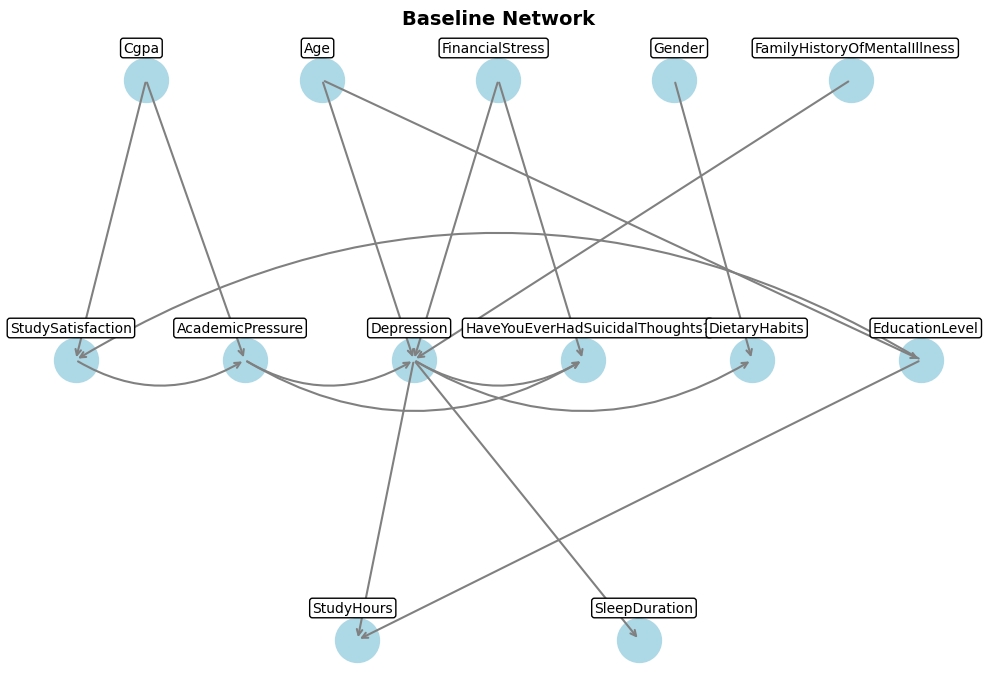

In [26]:
# Define the network structure
network_baseline = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Depression"),
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Depression"),
    ("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    #("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_baseline = BayesianNetwork(network_baseline)

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN_baseline.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Baseline Network")

### Model 2: Network with a latent variable

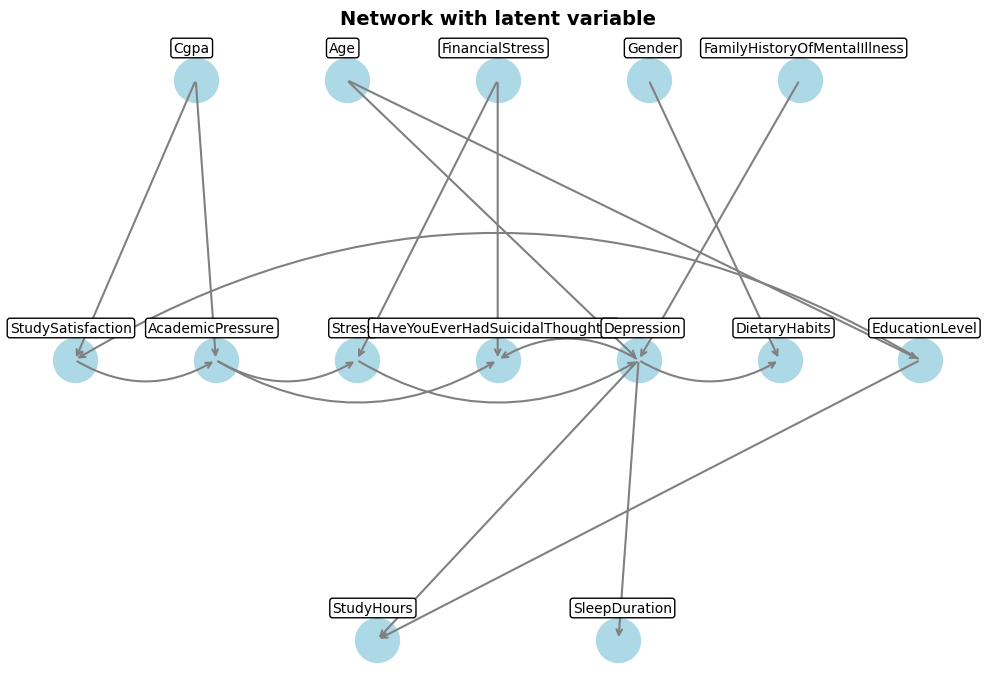

In [27]:
# Define the network structure
network_latent = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("StudySatisfaction","AcademicPressure"),
    ("Cgpa", "StudySatisfaction"),
    ("AcademicPressure","Stress"),                              # added Stress
    ("Stress","Depression"),                                    # added Stress
    ("Cgpa","AcademicPressure"),
    ("Age","EducationLevel"),
    ("FinancialStress","Stress"),                               # added Stress
    ("Stress","Depression"),                                    # added Stress
    ("AcademicPressure","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("FinancialStress","HaveYouEverHadSuicidalThoughts?"),
    #("Depression","StudySatisfaction"),
    ("EducationLevel","StudySatisfaction"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("EducationLevel","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_latent = BayesianNetwork(network_latent, latents=["Stress"])

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN_latent.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Network with latent variable")

### Model 3: Network with unified variables

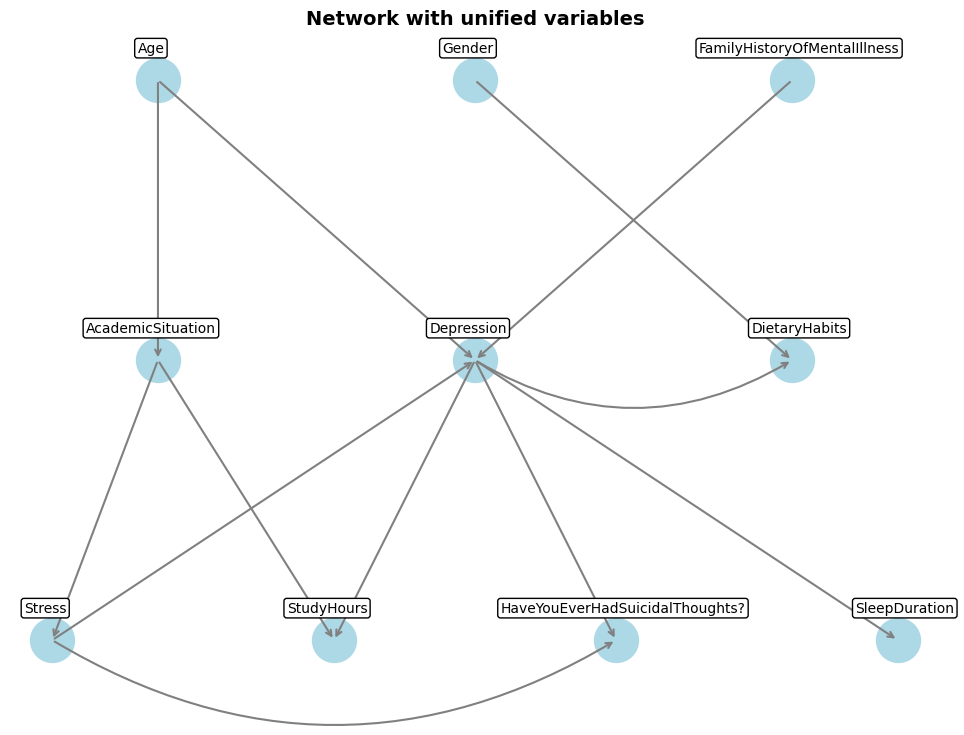

In [28]:
# Define the network structure
network_unified = [
    ("Depression","HaveYouEverHadSuicidalThoughts?"),
    ("AcademicSituation","Stress"),
    # ("AcademicSituation", "AcademicSituation"),
    ("Stress","Depression"),
    ("AcademicSituation","Stress"),
    ("Age","AcademicSituation"),
    ("Stress","Depression"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    ("Age","Depression"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("Stress","HaveYouEverHadSuicidalThoughts?"),
    # ("AcademicSituation", "AcademicSituation"),
    ("Depression","DietaryHabits"),
    ("Depression","StudyHours"),
    ("AcademicSituation","StudyHours"),
    ("Gender","DietaryHabits"),
    ("FamilyHistoryOfMentalIllness","Depression"),
    ('Depression','SleepDuration')
]

# Build the network
BN_unified = BayesianNetwork(network_unified)

# Plot its graph
G = nx.DiGraph()
G.add_edges_from(BN_unified.edges())
pos = hierarchical_layout(G, horizontal_spacing=3.0)
draw_graph(G, pos, title="Network with unified variables")

## Fit models

In [ ]:
models = {
    "Baseline Network" : BN_baseline, 
    # "Network with latent variable" : BN_latent, 
    # "Network with unified variables" : BN_unified
}
data_new = data.drop(columns=["EducationCategory", "Regions"])

In [ ]:
from pgmpy.estimators import ExpectationMaximization, BayesianEstimator
random_seed = 42

# Fit Bayesian Network using Expectation-Maximization
for name, mod in models.items():    
    # We explicitly fit since otherwise we can't set the seed
    em = ExpectationMaximization(mod, data_new)
    estimated_params = em.get_parameters(seed=random_seed)
    mod.cpds = estimated_params
    if not mod.check_model() : print(f'Model \"{name}\" check failed')

AttributeError: 'BayesianNetwork' object has no attribute 'get_parameters'

In [56]:
from pgmpy.estimators import ExpectationMaximization, BayesianEstimator
BN_baseline.fit(data_new, estimator=BayesianEstimator)

In [50]:
import numpy as np
from pgmpy.inference import VariableElimination

def compute_log_likelihood(model, data):
    """
    Computes the log-likelihood of a dataset given a Bayesian Network model, handling latent variables automatically.
    
    Parameters:
        model (BayesianNetwork): The Bayesian Network model.
        data (pd.DataFrame): A DataFrame where each row represents an observation with observed variable values.
    
    Returns:
        float: The log-likelihood of the dataset given the model.
    """
    # Identify observed and latent variables
    all_vars = set(model.nodes())
    observed_vars = set(data.columns)  # Columns represent observed variables
    latent_vars = all_vars - observed_vars
    
    # Initialize inference
    inference = VariableElimination(model)
    
    log_likelihood = 0
    for _, row in data.iterrows():
        sample = row.dropna().to_dict()  # Convert row to dictionary, ignoring NaN values
        
        # Compute joint probability of observed variables by marginalizing out latent variables
        query_result = inference.query(variables=list(latent_vars), evidence=sample)
        prob = np.sum(query_result.values) if isinstance(query_result.values, np.ndarray) else query_result.values
        
        if prob > 0:
            log_likelihood += np.log(prob)
        else:
            log_likelihood += -np.inf  # Handle log(0) case
    
    return log_likelihood


In [53]:
compute_log_likelihood(BN_latent, data_new)

-4.072298054325074e-13

In [57]:
from pgmpy.metrics import log_likelihood_score
log_likelihood_score(BN_baseline, data_new)

-407433.2190509852

In [44]:
def compute_bic(model, data):
    """
    Computes the Bayesian Information Criterion (BIC) score for a given Bayesian Network model and dataset.
    
    Parameters:
        model (BayesianNetwork): The Bayesian Network model.
        data (pd.DataFrame): A DataFrame where each row represents an observation with observed variable values.
    
    Returns:
        float: The BIC score of the model given the dataset.
    """
    log_likelihood = compute_log_likelihood(model, data)
    num_params = sum(np.prod(cpd.cardinality) - 1 for cpd in model.get_cpds())  # Total number of parameters
    num_samples = len(data)  # Number of data points
    
    bic = log_likelihood - (num_params / 2) * np.log(num_samples)
    return bic

compute_bic(BN_latent, data_new)

-3576.8756291535515

## Evaluate Models

In [ ]:
evaluation_df = pd.DataFrame({
    "" : [],
})

for name, mod in models.items():    
    ...
    evaluation_df.iloc[len(evaluation_df)] = []
    
display(evaluation_df.sort_values(by=""))